In [70]:
import numpy as np
import geopandas
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
from pysheds.grid import Grid
from pygeotools.lib import geolib,iolib
from imview.lib import pltlib
import pandas as pd

In [71]:
%matplotlib notebook
%matplotlib notebook

In [2]:
ds = iolib.fn_getds('reprojected_DEM.tif')
grid = Grid.from_raster('reprojected_DEM.tif','dem')
# fill the depressions and flats
grid.fill_depressions(data='dem',out_name='filled_dem',nodata_in=grid.nodata,nodata_out=grid.nodata)
grid.resolve_flats(data='filled_dem',nodata_in=grid.nodata,nodata_out=grid.nodata,out_name='filled_flats_dem')
#calculate flow direction
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
grid.flowdir('filled_flats_dem',out_name='dir',dirmap=dirmap)
#calculate flow accumulation
grid.accumulation(data='dir',out_name='acc',nodata_in=grid.nodata,nodata_out=grid.nodata)
#clip to watershed boundary, watershed is obtained from QGIS
grid.read_raster('final_watershed.tif','catch')
grid.clip_to('catch')

/home/shashank/.conda/envs/bhushanPy3/lib/python3.6/site-packages/pysheds-0.2.2-py3.6.egg/pysheds/grid.py:2932: RuntimeWarning: overflow encountered in add


In [13]:
# store values in masked arrays for further processing
filled_dem = np.ma.masked_where(grid.view('filled_flats_dem')==grid.nodata,(grid.view('filled_flats_dem')))
flow_acc_catchment = np.ma.masked_where(grid.view('acc')==grid.nodata,(grid.view('acc')))
flow_dir_catchment = np.ma.fix_invalid(grid.view('dir'))

<IPython.core.display.Javascript object>


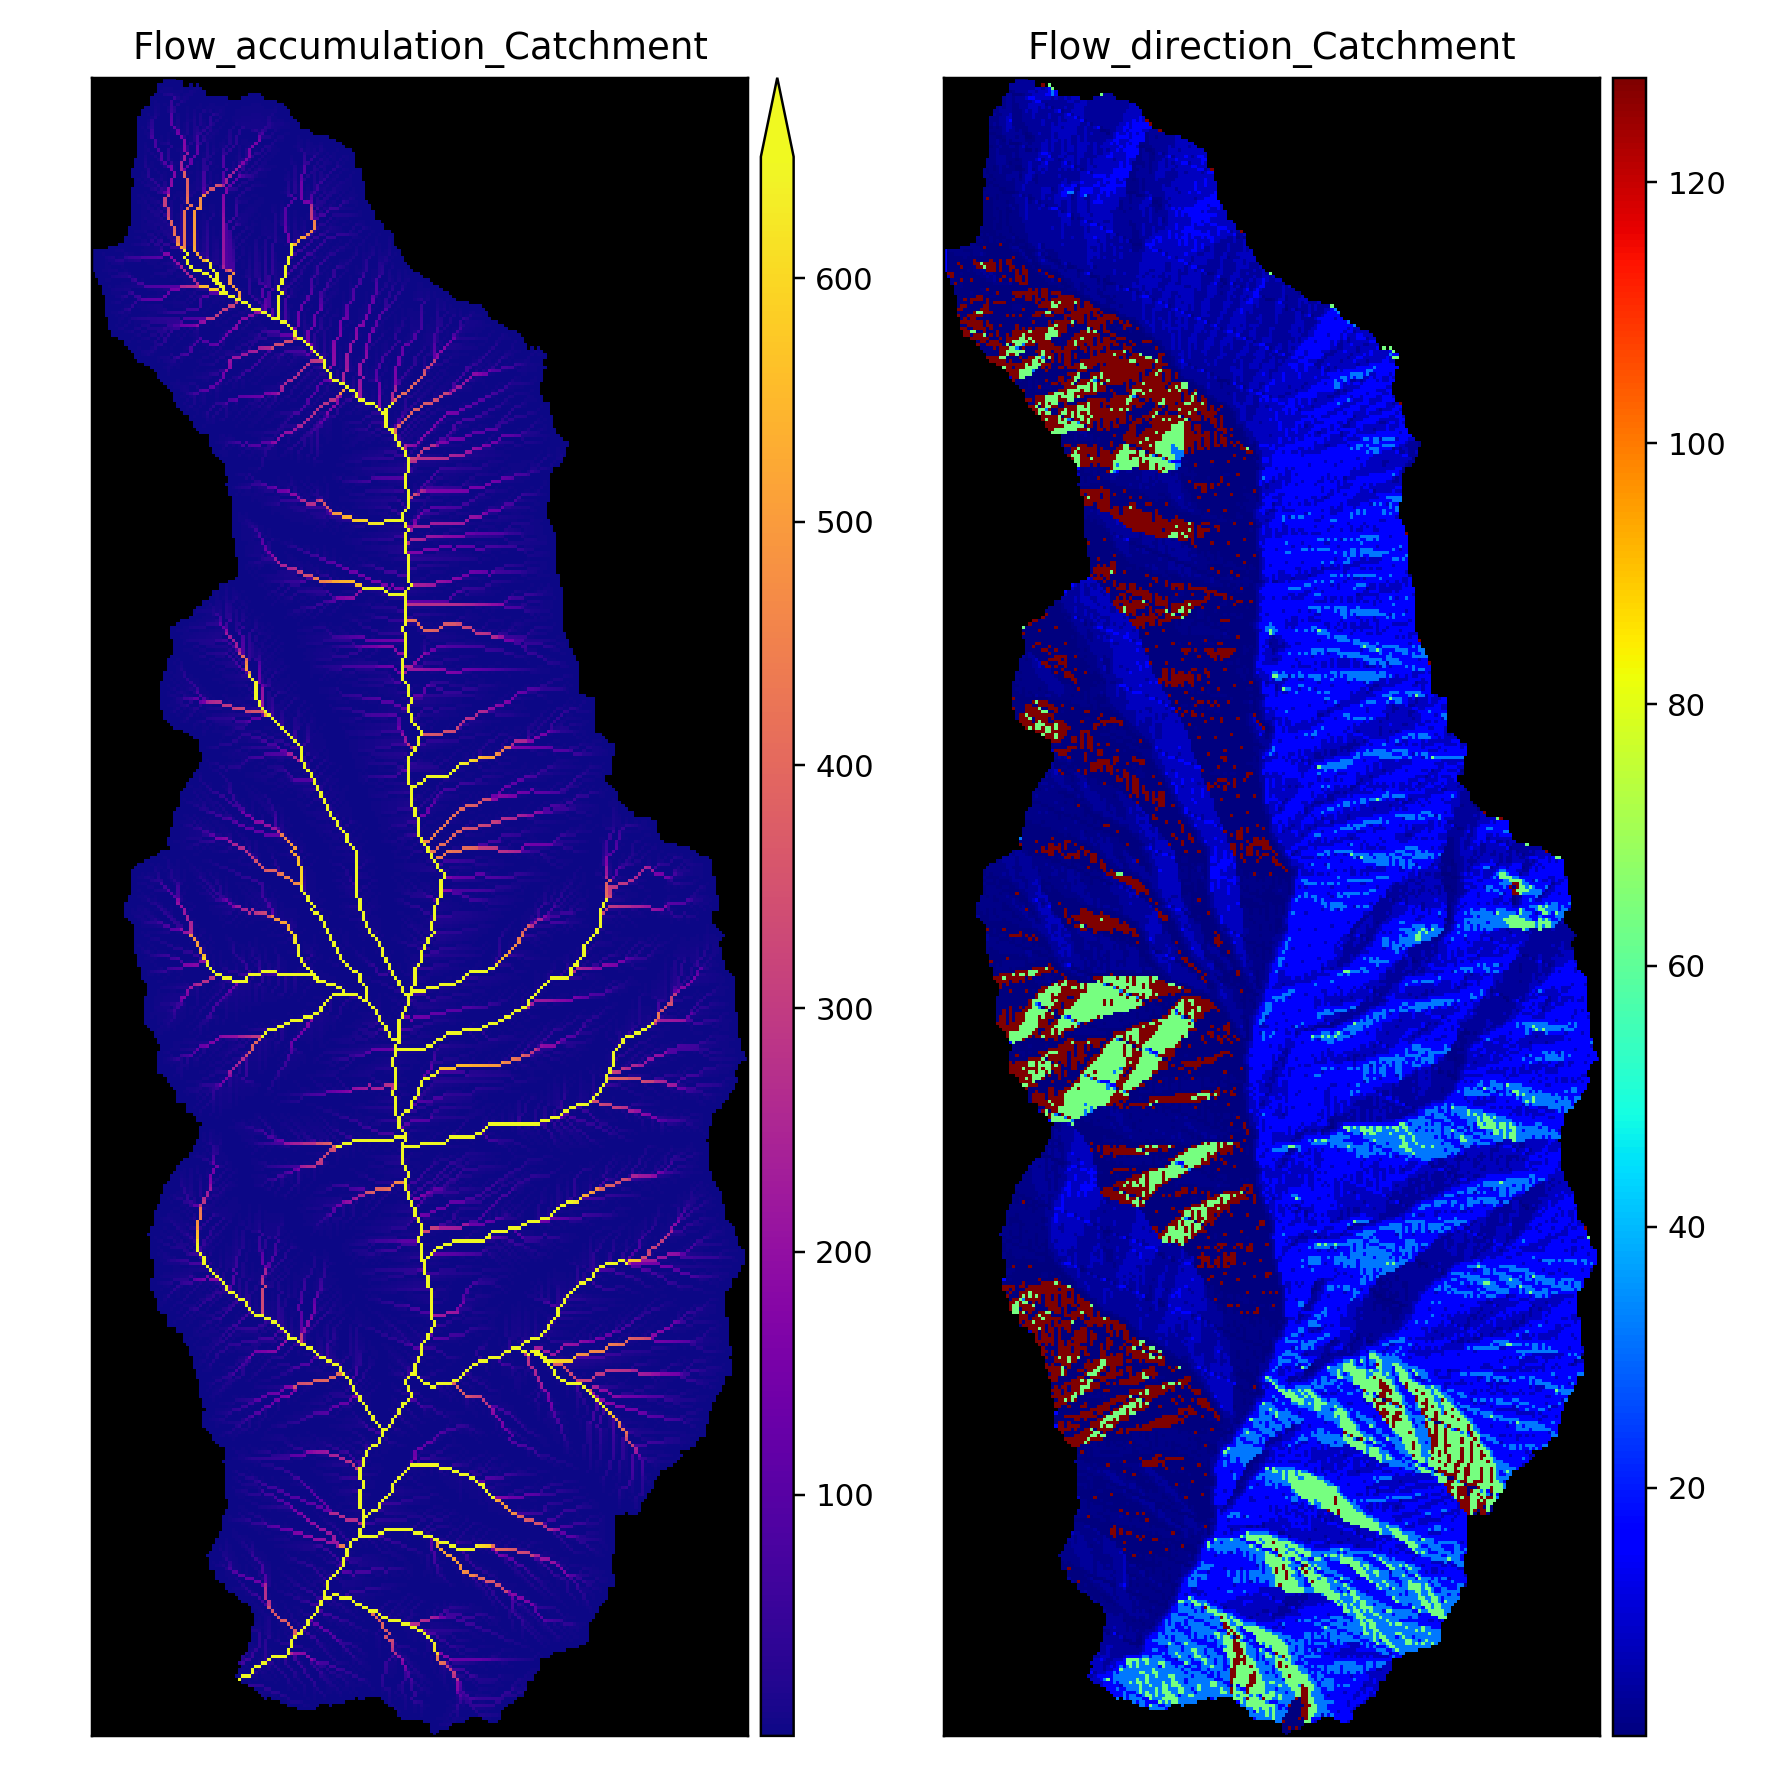

In [72]:
# Plot flow direction and flow accumulation
fig,ax = plt.subplots(1,2,figsize=(8,8))
pltlib.iv(flow_acc_catchment,ax=ax[0],cmap='plasma',title='Flow_accumulation_Catchment')
pltlib.iv(flow_dir_catchment,ax=ax[1],cmap='jet',title='Flow_direction_Catchment')
fig.savefig('Flow_accumulation_direction.png',dpi=600)

<IPython.core.display.Javascript object>


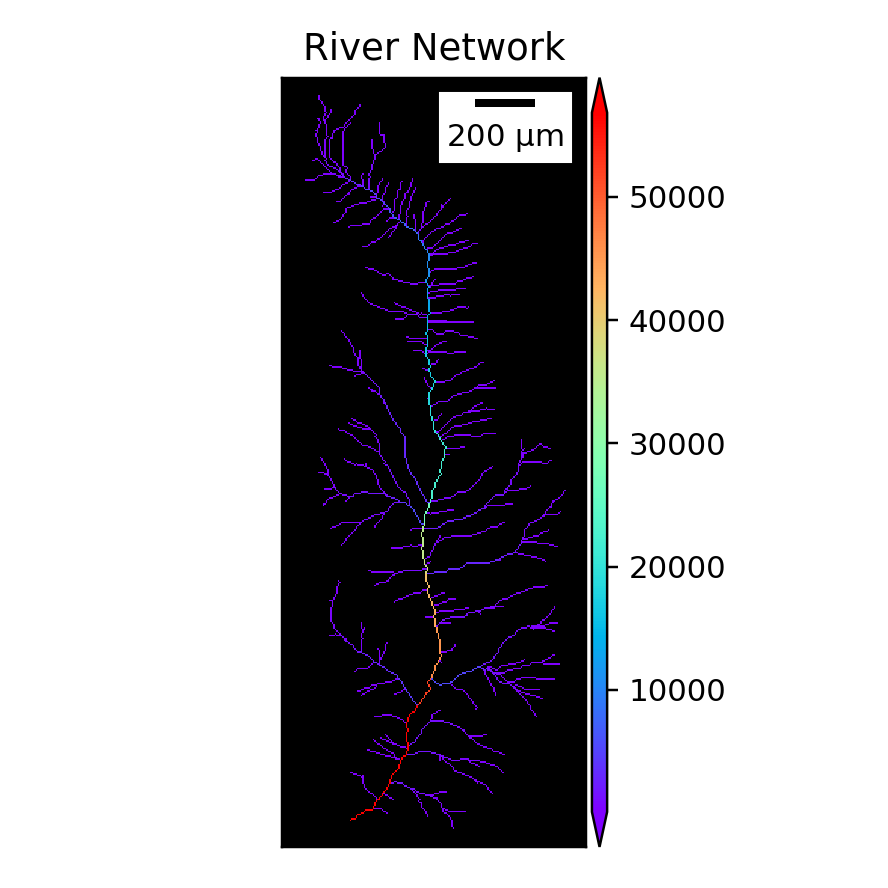

In [126]:
#plot the river network using a threshold of accumulation >= 100 in the catchment
fig,ax = plt.subplots(figsize=(4,4))
river_network = np.ma.masked_less(flow_acc_catchment,100)
pltlib.iv(river_network,ax=ax,ds=ds,cmap='rainbow',title = 'River Network')
fig.savefig('river_network.png',dpi=600)

In [10]:
resolution_of_dem = ds.GetGeoTransform()[1]
print (resolution_of_dem)

28.89036664823402

In [11]:
catchment_area = flow_acc_catchment*resolution_of_dem

/home/shashank/.conda/envs/bhushanPy3/lib/python3.6/site-packages/numpy/ma/core.py:1019: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)


In [14]:
#Write out filled DEM
iolib.writeGTiff(filled_dem,'Final_filled_DEM.tif',ds)

In [16]:
#Calculate Percent Slope
!gdaldem slope -p Final_filled_DEM.tif Percent_Slope.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [17]:
#read percent slope as masked array
percent_slope_catchment = iolib.fn_getma('Percent_Slope.tif')

<IPython.core.display.Javascript object>


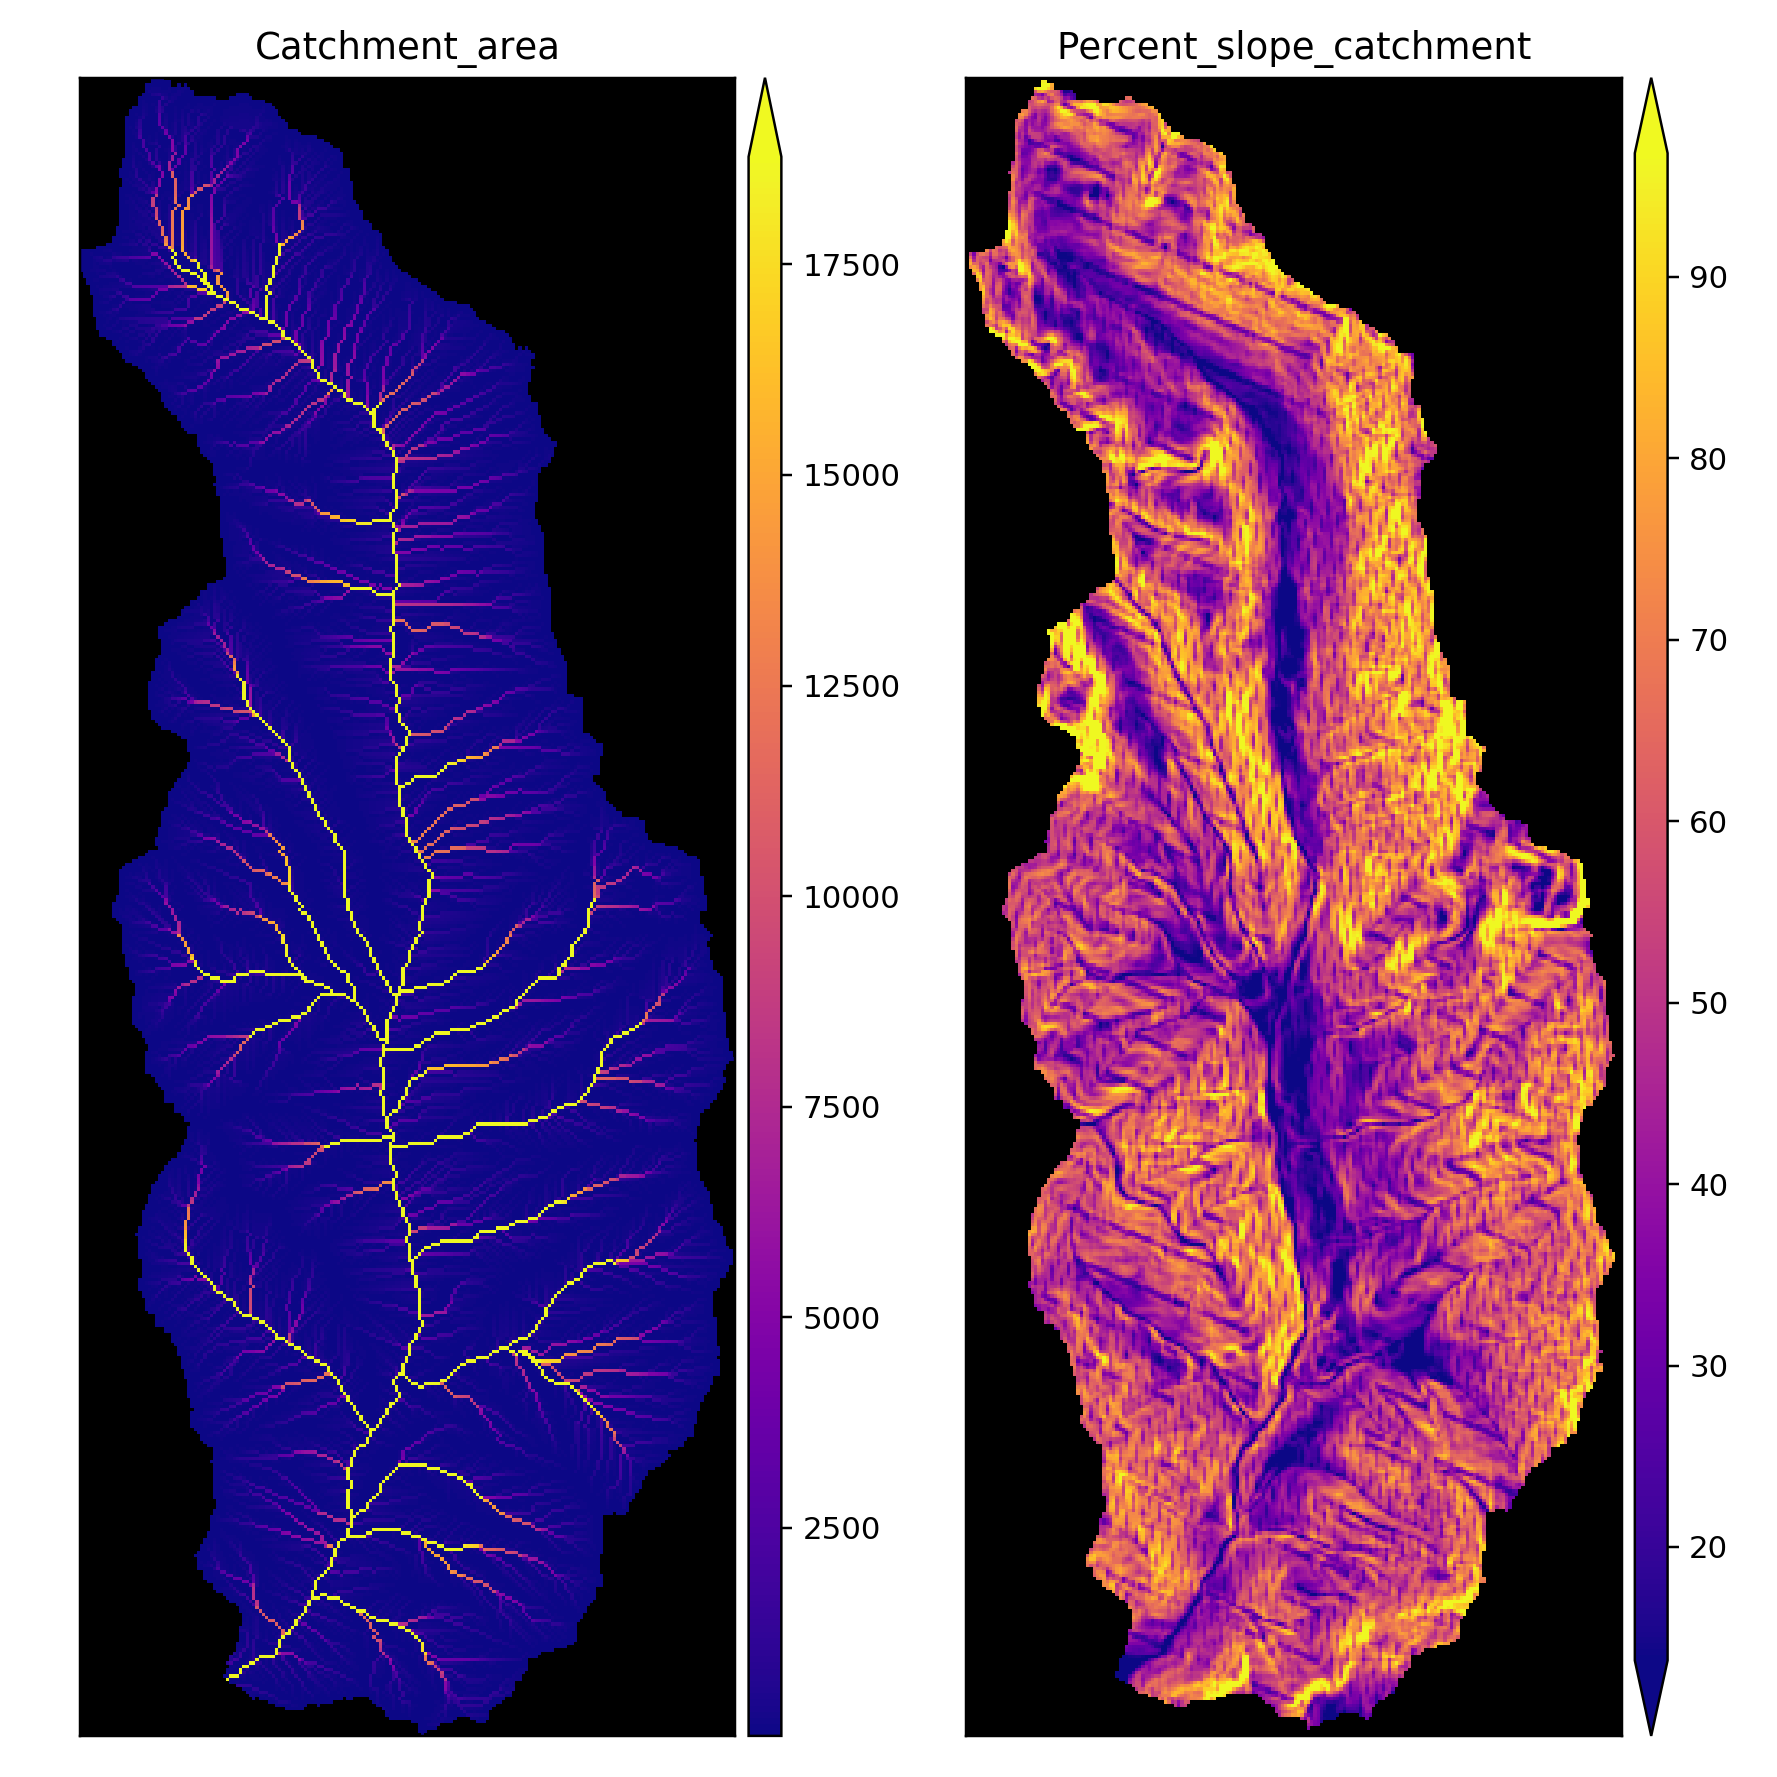

In [73]:
#plot catchment area and percent slope catchment
fig,ax = plt.subplots(1,2,figsize=(8,8))
pltlib.iv(catchment_area,ax=ax[0],cmap='plasma',title='Catchment_area')
pltlib.iv(percent_slope_catchment,ax=ax[1],cmap='plasma',title='Percent_slope_catchment')
fig.savefig('Catchment_area_slope.png',dpi=600)

In [28]:
#Converting slope percent to slope
slope = percent_slope_catchment*0.01
#masking slope less than or equal to 0.0
slope = np.ma.masked_less_equal(slope,0)
print ("Least value of slope is = "+str(np.ma.min(slope)))

Least value of slope is = 0.005154003


In [31]:
top_model_values = np.ma.log(catchment_area/(slope))

In [32]:
print ('Maximum wetness index = '+ str(np.ma.max(top_model_values)))
print ('Minimum wetness index = '+ str(np.ma.min(top_model_values)))
print ('Mean wetness index = '+ str(np.ma.mean(top_model_values)))

Maximum wetness index = 18.865674848110217
Minimum wetness index = 2.653636410881833
Mean wetness index = 5.730137630068871


<IPython.core.display.Javascript object>


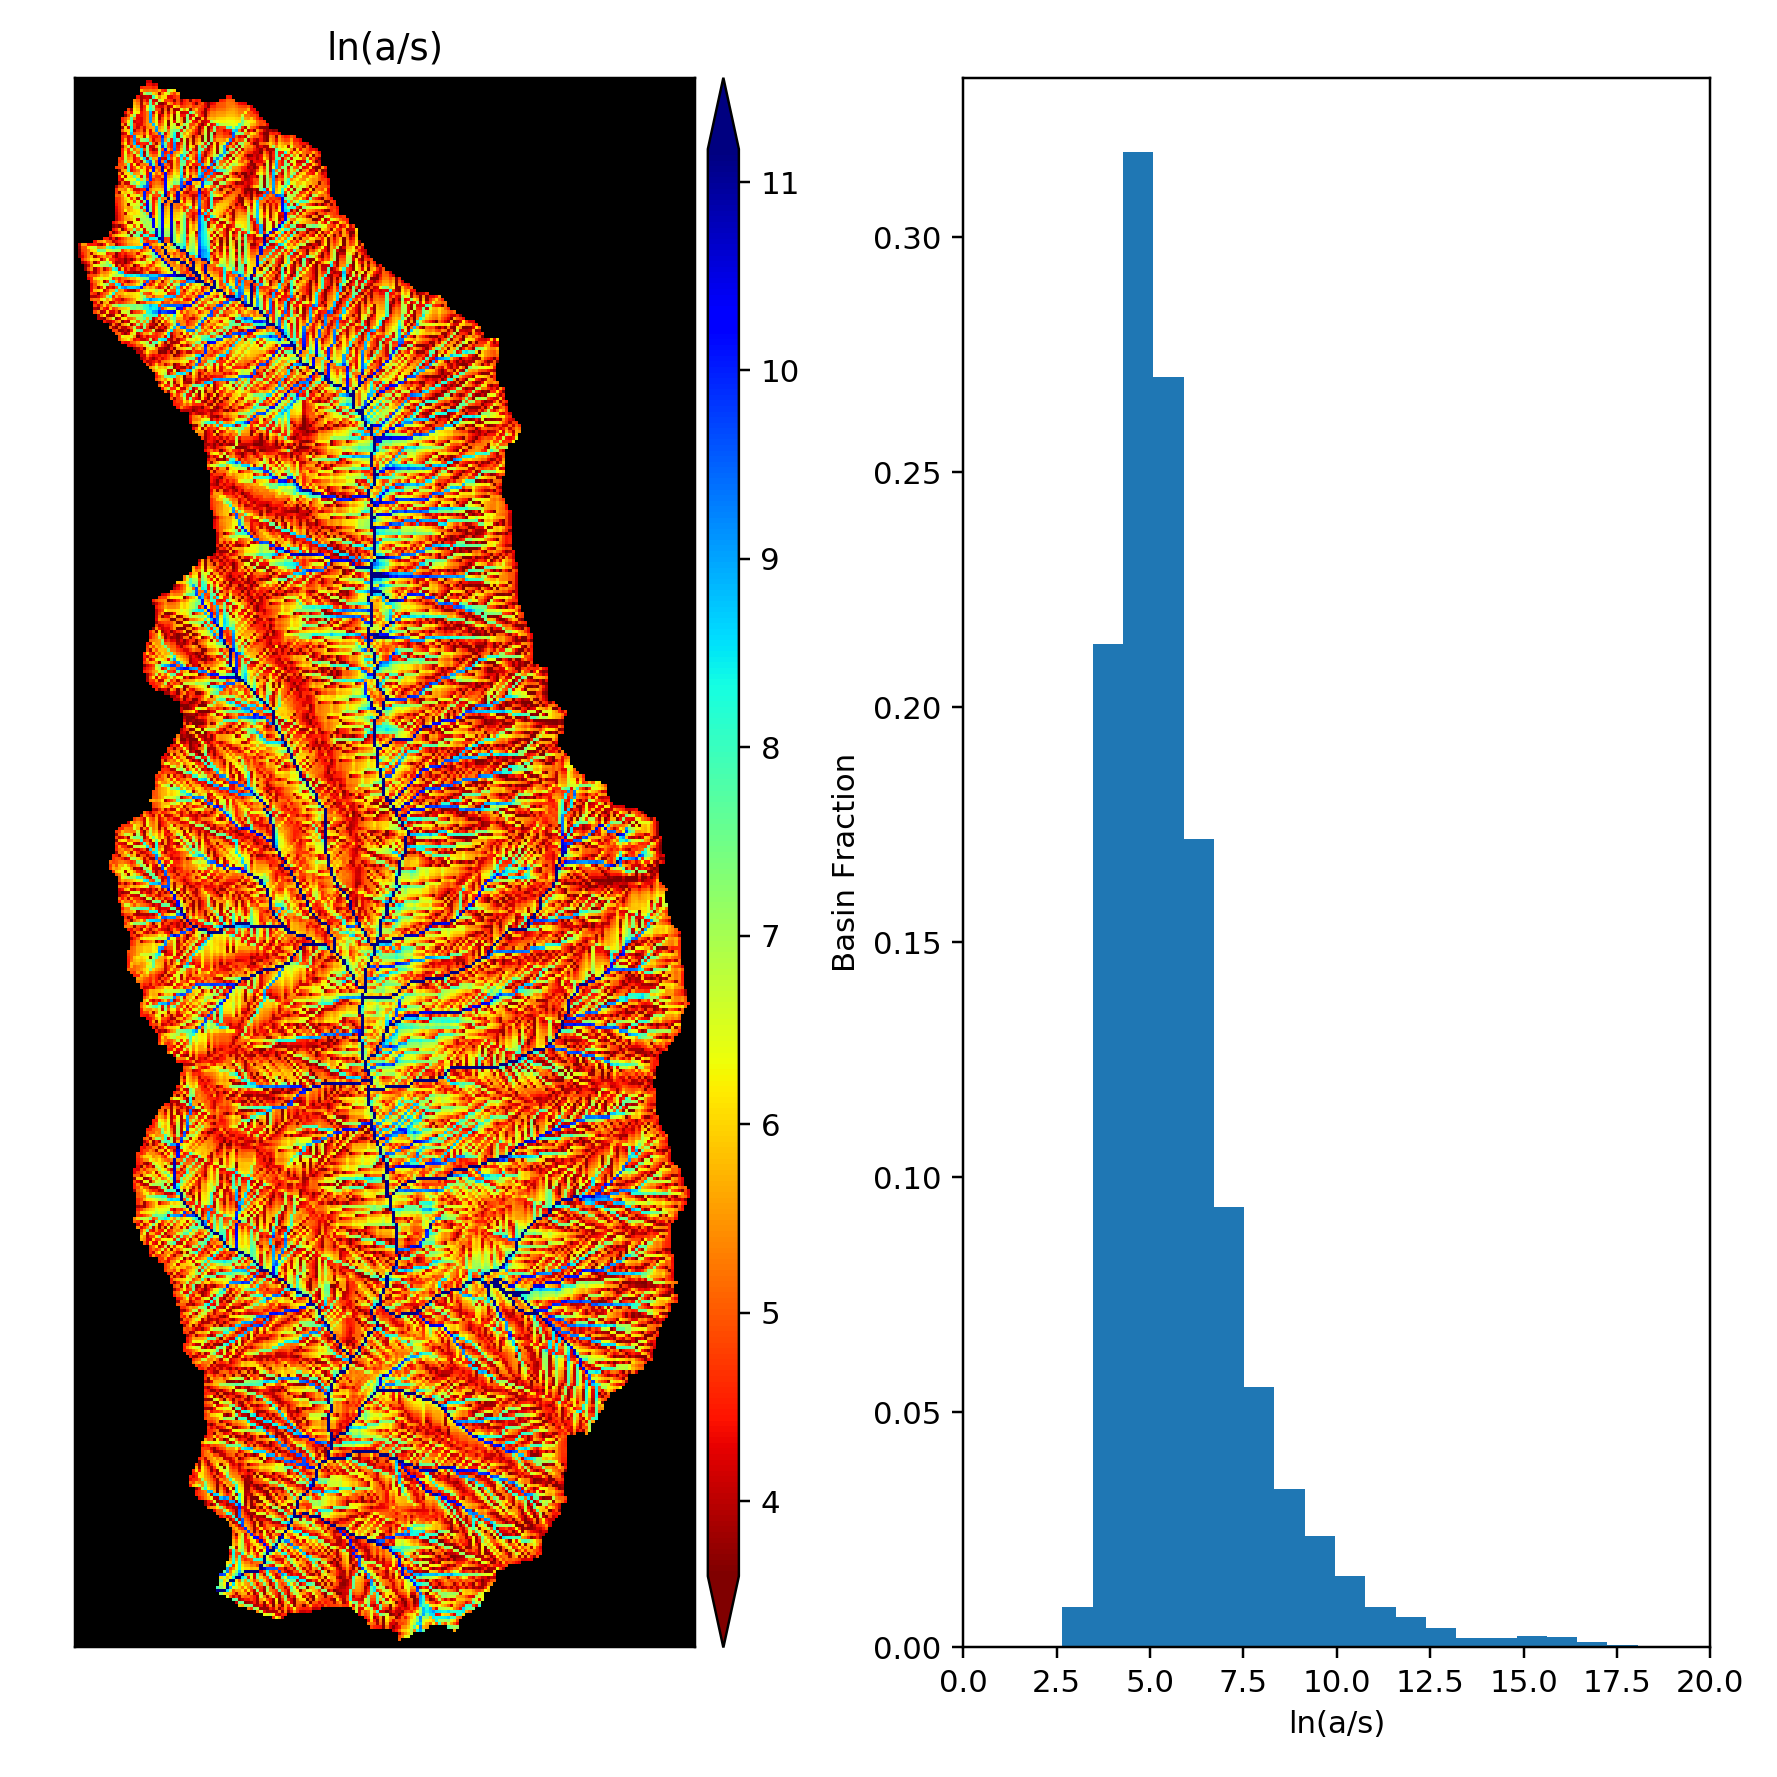

/home/shashank/.conda/envs/bhushanPy3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


In [74]:
#plotting wetness index
fig,ax = plt.subplots(1,2,figsize=(8,8))
pltlib.iv(top_model_values,ax=ax[0],title='ln(a/s)',cmap='jet_r')
ax[1].hist(np.ma.compressed(top_model_values),bins = 20, normed =True)
ax[1].set_xlabel('ln(a/s)')
ax[1].set_ylabel('Basin Fraction')
ax[1].set_xlim(0,20)
plt.tight_layout()
fig.savefig('Wetness_index.png',dpi=600)


<IPython.core.display.Javascript object>


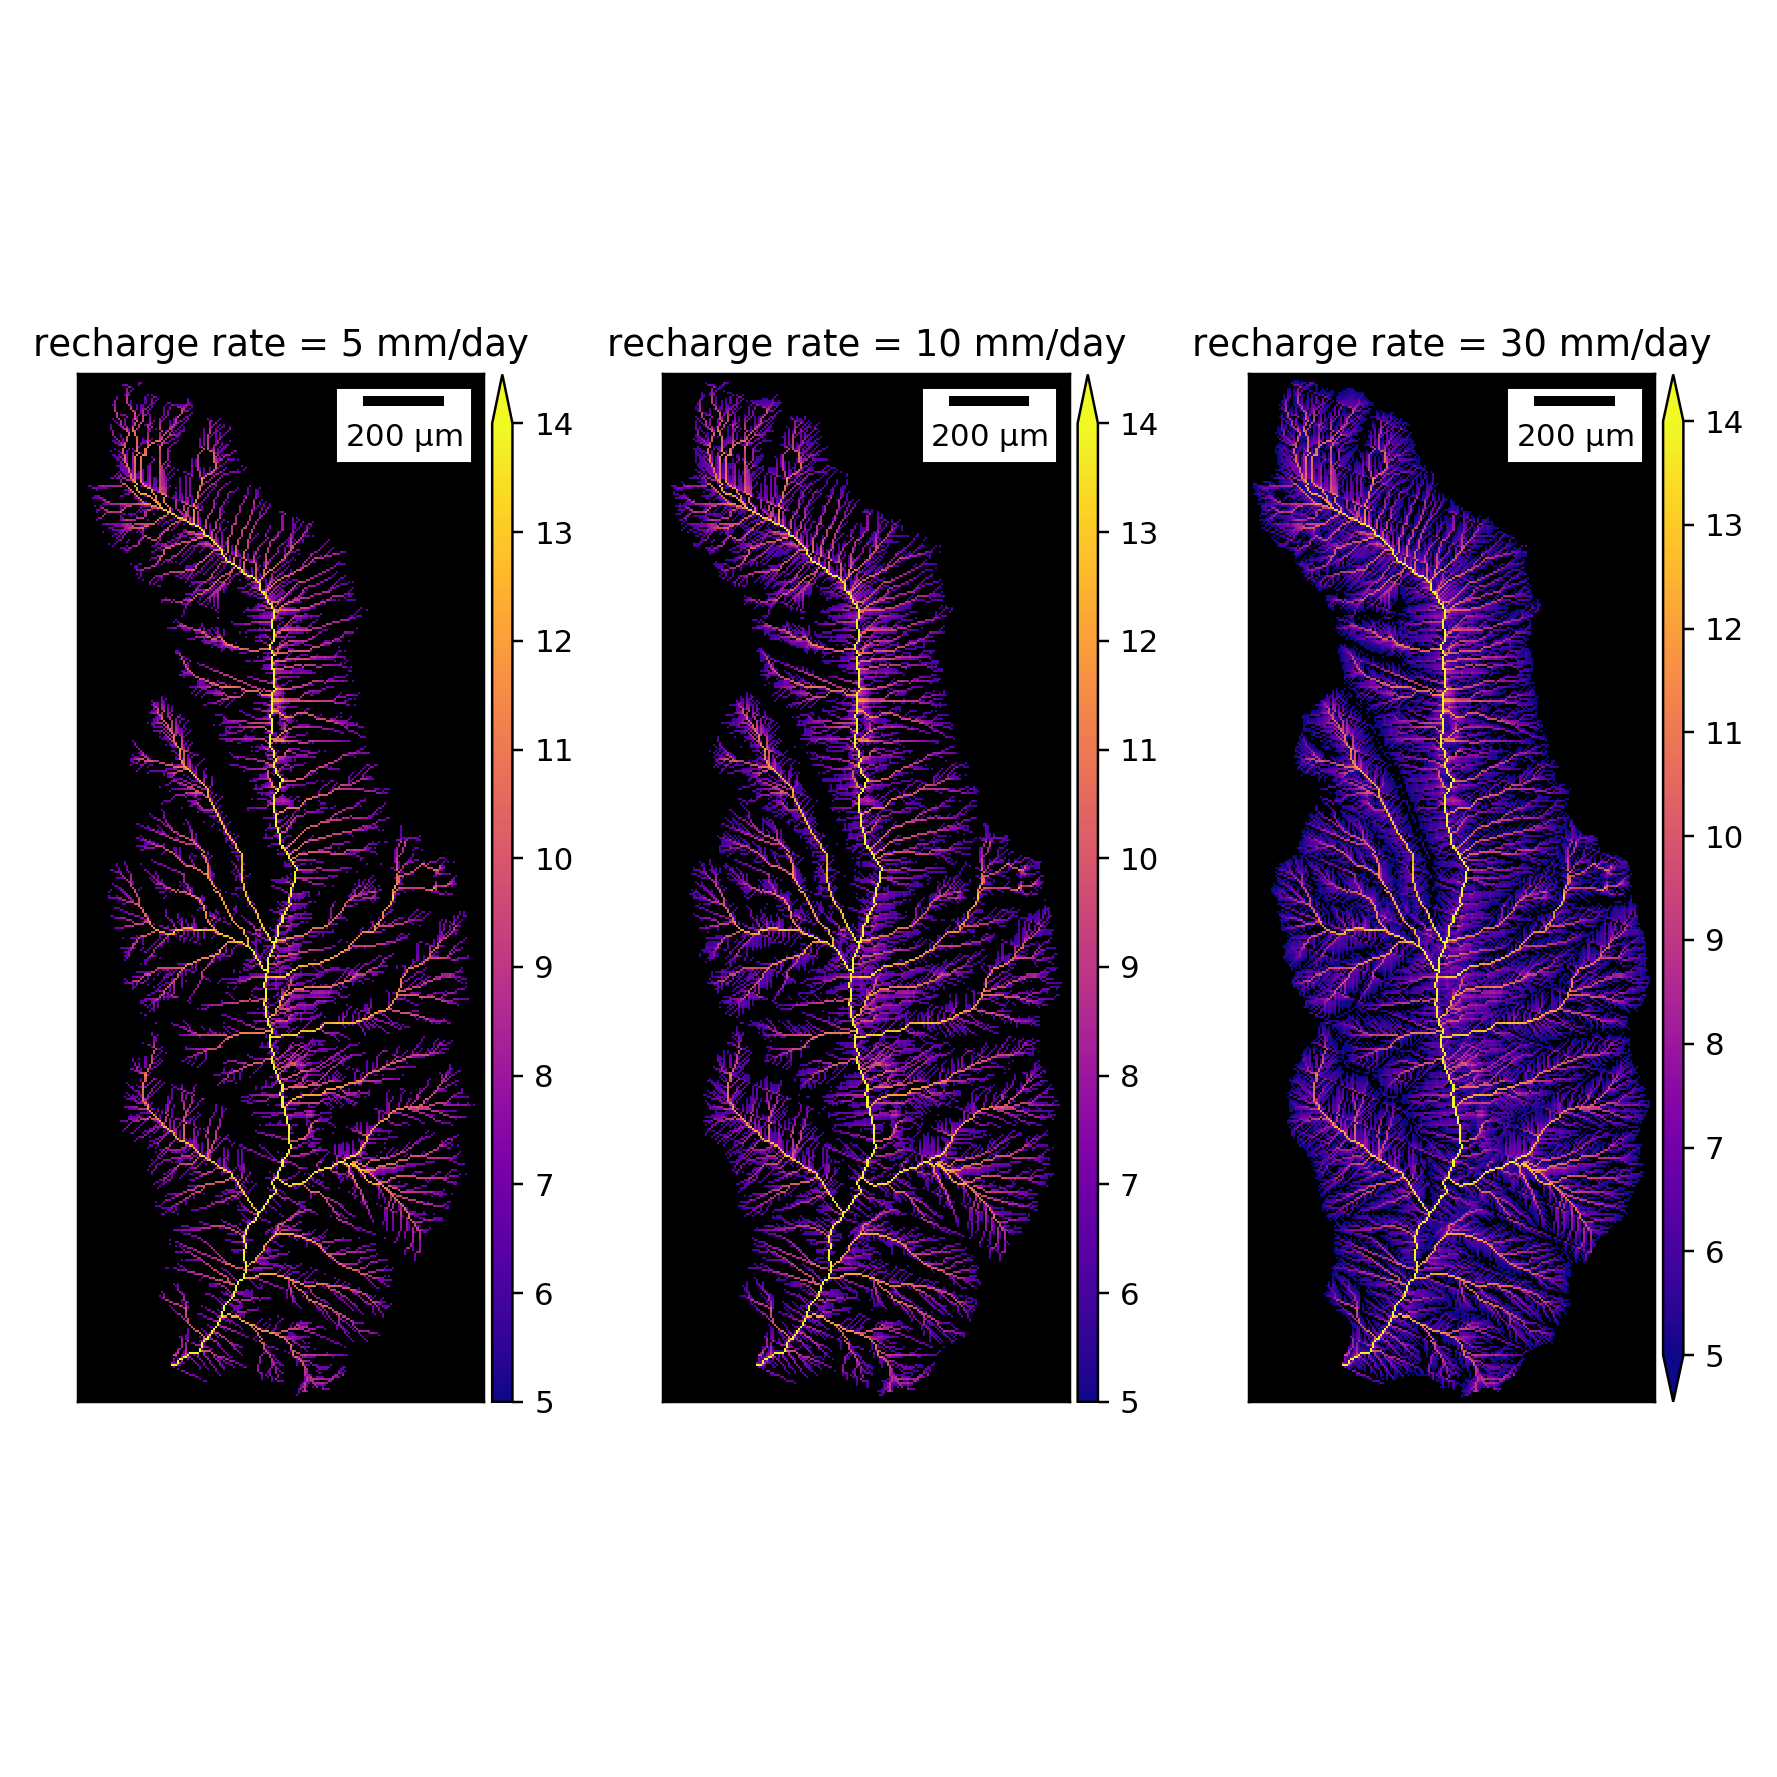

In [75]:
#part 3
r1 = 5 #mm/day
r2 = 10 #mm/day
r3 = 30 #mm/day
t = 3 #m2/day
#Converting mm/day to m/day
#Multiplying by 1000000
r1 = r1*0.001 #m/day
r2 = r2*0.001 #m/day
r3 = r3*0.001 #m/day
sat_threshold1 = np.log(t/r1)
sat_threshold2 = np.log(t/r2)
sat_threshold3 = np.log(t/r3)
sat_area1 = np.ma.masked_less(top_model_values,sat_threshold1)
sat_area2 = np.ma.masked_less(top_model_values,sat_threshold2)
sat_area3 = np.ma.masked_less(top_model_values,sat_threshold3)
fig,ax = plt.subplots(1,3,figsize=(8,8))
pltlib.iv(sat_area1,ax=ax[0],title='recharge rate = 5 mm/day',ds=ds,cmap='plasma',clim=(5,14))
pltlib.iv(sat_area2,ax=ax[1],title='recharge rate = 10 mm/day',ds=ds,cmap='plasma',clim=(5,14))
pltlib.iv(sat_area3,ax=ax[2],title='recharge rate = 30 mm/day',ds=ds,cmap='plasma',clim=(5,14))
plt.tight_layout()
fig.savefig('Saturated_Fractions.png',dpi=600)

In [51]:
saturated_area_fraction1 = np.ma.count(sat_area1)/np.ma.count(top_model_values)
saturated_area_fraction2 = np.ma.count(sat_area2)/np.ma.count(top_model_values)
saturated_area_fraction3 = np.ma.count(sat_area3)/np.ma.count(top_model_values)
print ('Saturated area fraction with a recharge rate of 5 mm/day = ' +str(saturated_area_fraction1))
print ('Saturated area fraction with a recharge rate of 10 mm/day = ' +str(saturated_area_fraction2))
print ('Saturated area fraction with a recharge rate of 30 mm/day = ' +str(saturated_area_fraction3))

Saturated area fraction with a recharge rate of 5 mm/day = 0.24886623965589788
Saturated area fraction with a recharge rate of 10 mm/day = 0.3886733055932177
Saturated area fraction with a recharge rate of 30 mm/day = 0.7110196830146337


In [136]:
print ('ln(t/r) for recharge rate of 5 mm/day = '+str(sat_threshold1))
print ('ln(t/r) for recharge rate of 10 mm/day = '+str(sat_threshold2))
print ('ln(t/r) for recharge rate of 30 mm/day = '+str(sat_threshold3))

ln(t/r) for recharge rate of 5 mm/day = 6.396929655216146
ln(t/r) for recharge rate of 10 mm/day = 5.703782474656201
ln(t/r) for recharge rate of 30 mm/day = 4.605170185988092


In [139]:
#part 4 Defining Topmodel
def topmodel(unique,counts,rb,p):
    """
    model expects eveything in units of m, time unit should also be same for all, eg., if it is day for 1, it is
    day for all other variables
    """
    data = np.vstack((unique,counts)).T
    df = pd.DataFrame(data,columns=['lam','freq'])
    df['frac'] = df['freq']/(df['freq'].sum())
    mean_lam = np.sum(unique*counts)/np.sum(counts)
    f = 5 #1/m
    n = 0.45
    theta_i = 0.3
    m = (n-theta_i)/f
    to = 3 #m2/day
    ln_t_rb = np.log(to/rb)
    mean_D = -m*(np.log(rb)-np.log(to)+mean_lam)
    mean_z = (-1/f)*(np.log(rb)-np.log(to)+mean_lam)
    df['cum_frac'] = df.frac.cumsum()
    mask = df['lam']>ln_t_rb
    mask1 = df['lam']<ln_t_rb
    df['sat_frac'] = ""
    df.loc[mask1, 'sat_frac'] = 0
    df.loc[mask, 'sat_frac'] = df.loc[mask,'frac']
    #df['cum_sat_frac'] = df.sat_frac.cumsum()
    df['D'] = mean_D-m*(df['lam']-mean_lam)
    mask2 = df['D']<0
    df.loc[mask2, 'D'] = 0
    df['z'] = mean_z-((1/f)*(df['lam']-mean_lam))
    mask3 = df['z']<0
    df.loc[mask3, 'z'] = 0
    df['rain'] = p
    df['D_p'] = df['D']-df['rain']
    mask4 = df['D_p']>0
    mask5 = df['D_p']<0
    df['Do'] = ""
    df.loc[mask4,'Do'] = df.loc[mask4,'D_p']
    df.loc[mask5,'Do'] = 0
    df['z_p'] = df['z']-(df['rain']/(n-theta_i))
    mask6 = df['z_p']>0
    mask7 = df['z_p']<0
    df['zo'] = ""
    df.loc[mask6,'zo'] = df.loc[mask6,'z_p']
    df.loc[mask7,'zo'] = 0
    mask8 = df['rain']>df['D']
    mask9 = df['rain']<=df['D']
    df['runoff'] = ""
    df.loc[mask8, 'runoff'] = df.loc[mask8,'rain']-df.loc[mask8, 'D']
    df.loc[mask9, 'runoff'] = 0
    mean_zo = np.sum(df.zo.values*df.frac.values)/np.sum(df.frac.values)
    mean_Do = np.sum(df.Do.values*df.frac.values)/np.sum(df.frac.values)
    mean_runoff = np.sum(df.runoff.values*df.frac.values)/np.sum(df.frac.values)
    return df,mean_runoff
    
    
    
    

In [140]:
# Round the wetness index value to the next highest integer
x = np.ceil(np.asarray(np.ma.compressed(top_model_values)))
#get the values of the unique values (lambda) and their counts (frequency) 
unique,counts = np.unique(x,return_counts=True)
# given rate of precipitation, which is converted to m
p = 50 #mm
p = p*0.001 #m
#Run the topmodel with recharge rate of 10 mm/day
df_recharge_10,mean_runoff_recharge_10 = topmodel(unique,counts,r2,p)

In [141]:
df_recharge_10

,lam,freq,frac,cum_frac,sat_frac,D,z,rain,D_p,Do,z_p,zo,runoff
0,3.0,14.0,0.000218,0.000218,0,0.081113,0.540756,0.05,0.031113,0.0311135,0.207423,0.207423,0
1,4.0,6880.0,0.107220,0.107438,0,0.051113,0.340756,0.05,0.001113,0.00111347,0.007423,0.00742316,0
2,5.0,19519.0,0.304191,0.411629,0,0.021113,0.140756,0.05,-0.028887,0,-0.192577,0,0.0288865
3,6.0,17154.0,0.267334,0.678963,0.267334,0.000000,0.000000,0.05,-0.050000,0,-0.333333,0,0.05
4,7.0,9697.0,0.151121,0.830084,0.151121,0.000000,0.000000,0.05,-0.050000,0,-0.333333,0,0.05
5,8.0,4612.0,0.071875,0.901959,0.071875,0.000000,0.000000,0.05,-0.050000,0,-0.333333,0,0.05
6,9.0,2492.0,0.038836,0.940795,0.0388362,0.000000,0.000000,0.05,-0.050000,0,-0.333333,0,0.05
7,10.0,1539.0,0.023984,0.964779,0.0239843,0.000000,0.000000,0.05,-0.050000,0,-0.333333,0,0.05
8,11.0,880.0,0.013714,0.978494,0.0137142,0.000000,0.000000,0.05,-0.050000,0,-0.333333,0,0.05
9,12.0,488.0,0.007605,0.986099,0.00760516,0.000000,0.000000,0.05,-0.050000,0,-0.333333,0,0.05


In [142]:
mean_runoff_recharge_10

0.038205558874741974

In [144]:
df_recharge_10.to_csv('Topmodel_Results_with_recharge_rate_of_10_mm_day.csv')